In [1]:
#Initialize the hardware

import matplotlib.pyplot as plt
import numpy as np
import time

from pylablib.devices.Andor import AndorSDK2Camera, ShamrockSpectrograph
from pylablib.devices import Andor

from ASIStage import ASIStage


print("SDK2 cameras:", Andor.get_cameras_number_SDK2())
print("Shamrock spectrographs:", Andor.list_shamrock_spectrographs())

#connect to the andor camera (Newton)
#cam = AndorSDK2Camera(temperature=-40, fan_mode="full")
cam = AndorSDK2Camera()

cam.set_temperature(-40,"True")


width, height = cam.get_detector_size()
print(f"Camera sensor size: {width} × {height} pixels")

# — Spectrometer —
# ShamrockSpectrograph doesn’t need a context manager
spec = ShamrockSpectrograph()
info = spec.get_device_info()  # e.g. ('SR0455', ...)
print("Spectrometer info:", info)

num_gratings = spec.get_gratings_number()
print(f"Number of gratings: {num_gratings}")

for i in range(1, num_gratings+1):
    info = spec.get_grating_info(i)
    print(f"Grating {i}: {info}")

spec.set_grating(1)  # 300 lines/mm



# --- Initialize stage with velocities ---
stage = ASIStage(xy_velocity=1000, z_velocity=50, units="mm")

print("\n=== TEST: Initial Positions ===")
print("XY:", stage.get_xy())
print("Z:", stage.get_z())

SDK2 cameras: 1
Shamrock spectrographs: ['SR0455', 'SR0455']
Camera sensor size: 1600 × 400 pixels
Spectrometer info: TDeviceInfo(serial_number='SR0455')
Number of gratings: 3
Grating 1: TGratingInfo(lines=300.0, blaze_wavelength='1000', home=-15983, offset=-22)
Grating 2: TGratingInfo(lines=600.0, blaze_wavelength='500', home=144133, offset=-100)
Grating 3: TGratingInfo(lines=1200.0, blaze_wavelength='300', home=304234, offset=0)

=== TEST: Initial Positions ===
XY: (1.49892, 1.50677)
Z: -0.45970000000000005


In [2]:
print("\n=== TEST: Initial Positions ===")
print("XY:", stage.get_xy())
print("Z:", stage.get_z())


=== TEST: Initial Positions ===
XY: (1.49892, 1.50677)
Z: -0.45970000000000005


In [3]:
# ---------------------------
# Configure Spectromter and Camera
# ---------------------------
exposure_time = 0.1  # seconds
em_gain = 160        # Gain between 0-255 for EMCCD models

# Set full vertical binning (FVB)
# FVB means bin across all vertical pixels — so ROI height is 1
sensor_width, sensor_height = cam.get_detector_size()

cam.set_read_mode("fvb")

cam.set_acquisition_mode(1) # set for a single scan


# cam.set_roi(0, cam.get_detector_size()[0])

cam.set_exposure(exposure_time)

cam.set_EMCCD_gain(em_gain)

cam.set_amp_mode(channel=1, oamp=0, hsspeed=0, preamp=2)

mode = cam.get_amp_mode(full=True)
print(f"Channel:      {mode.channel}")
print(f"Amplifier:    {'EM' if mode.oamp==0 else 'Conventional'}")
print(f"HS Speed idx: {mode.hsspeed} → {mode.hsspeed_MHz:.2f} MHz")
print(f"Preamp idx:   {mode.preamp} → {mode.preamp_gain:.1f}×")

# Optional: Print some status
print(f"Exposure time: {cam.get_exposure()} s")
print(f"EM gain: {cam.get_EMCCD_gain()}")
print(f"Read Mode: {cam.get_read_mode()}")
print(f"Acquisition Mode: {cam.get_acquisition_mode()}")



Channel:      1
Amplifier:    EM
HS Speed idx: 0 → 2.50 MHz
Preamp idx:   2 → 4.0×
Exposure time: 0.10000000149011612 s
EM gain: (160, 0)
Read Mode: fvb
Acquisition Mode: single


In [3]:
cam.get_status()

'idle'

In [7]:
cam.get_temperature()

-31.22100067138672

In [19]:
spec.get_wavelength()

9.200000000000001e-07

In [26]:
spec.set_wavelength(920e-9)

spec.setup_pixels_from_camera(cam)
specAxis = spec.get_calibration()
# If it’s not already an array, convert it:
specAxis = np.array(specAxis/1e-9)

# Now get min/max:
wl_min = specAxis.min()
wl_max = specAxis.max()
print(f"Wavelength range: {wl_min:.2f} nm to {wl_max:.2f} nm")

Wavelength range: 787.11 nm to 1051.93 nm


Spectrum acquired. Length: 5


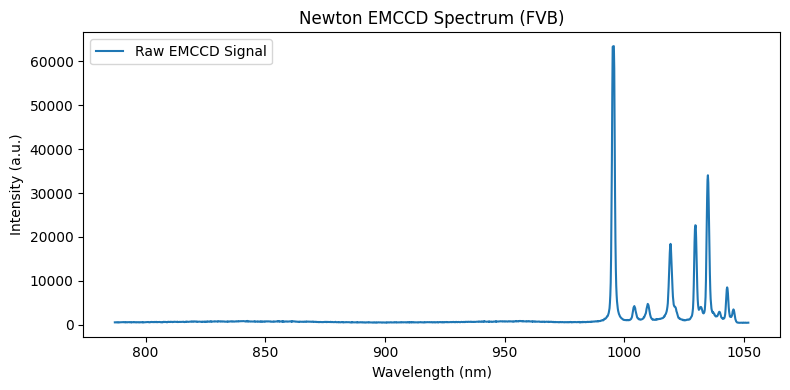

In [9]:


frame = cam.grab(5)
stack = np.vstack(frame)  
avg_spectrum = stack.mean(axis=0)


#frame = cam.snap()

print("Spectrum acquired. Length:", len(frame))

# ---------------------------
# Plot the spectrum
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(specAxis,avg_spectrum, label='Raw EMCCD Signal')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Newton EMCCD Spectrum (FVB)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# --- Absolute Move ---
#print("\n=== TEST: Absolute Move ===")
#stage.move_xy(1, 1)   # 1 mm
#stage.move_z(0.5)     # 0.5 mm
#print("After absolute move:")
#print("XY:", stage.get_xy())
#print("Z:", stage.get_z())

In [10]:
import numpy as np
import time


def scan_xy_simple(stage, cam, spec,
                   x_size_um, y_size_um, Nx, Ny,
                   n_frames=5, settle_s=0.1):
    # compute mm ranges
    
    x0, y0 = stage.get_xy()


    x_mm = x_size_um*1e-3; y_mm = y_size_um*1e-3
    x_pos = np.linspace(x0 - x_mm/2, x0 + x_mm/2, Nx)
    y_pos = np.linspace(y0 - y_mm/2, y0 + y_mm/2, Ny)

    # prep wavelength axis
    spec.setup_pixels_from_camera(cam)
    specAxis = np.array(spec.get_calibration())
    Npix = specAxis.size
    data = np.zeros((Nx, Ny, Npix), float)

    for ix, x in enumerate(x_pos):
        
        stage.move_xy(x, y0, wait=True)
        time.sleep(settle_s)

        for iy, y in enumerate(y_pos):
            
            stage.move_xy(x, y, wait=True)
            time.sleep(settle_s)

            frames = cam.grab(n_frames)
            stack  = np.vstack([f.squeeze() for f in frames])
            data[ix, iy] = stack.mean(axis=0)

    return specAxis, data

# …then call it once velocities are set…
specAxis, cube = scan_xy_simple(
    stage, cam, spec,
    x_size_um=1000, y_size_um=1000,
    Nx=10, Ny=10,
    n_frames=5,
    settle_s=0.1
)
print("Scan done, cube.shape =", cube.shape)



Scan done, cube.shape = (10, 10, 1600)


In [18]:
np.savez('scan_results4.npz',
         specAxis=specAxis,
         data=cube)
print("Saved to scan_results.npz")

Saved to scan_results.npz


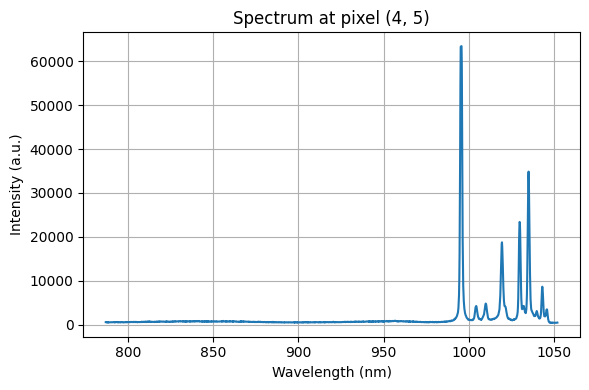

In [17]:

# choose your pixel indices (Python is 0-based)
row, col = 4, 5    # top-left corner
spectrum = cube[row, col, :]

plt.figure(figsize=(6,4))
plt.plot(specAxis, spectrum, lw=1.5)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title(f"Spectrum at pixel ({row}, {col})")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import time

def scan_xy_spectra_centered_fixed(
    st, cam, spec,
    x_size_um, y_size_um,
    Nx, Ny,
    center_x_mm, center_y_mm,
    n_frames=5, settle_s=0.5
):
    """
    Raster-scan an X×Y region (in µm) on an Nx×Ny grid,
    centered at (center_x_mm, center_y_mm) in mm.
    Acquire n_frames per point, average them, and return
    (specAxis_nm, data_cube) of shape (Nx, Ny, Npixels).
    """
    # Convert µm → mm
    x_size_mm = x_size_um * 1e-3
    y_size_mm = y_size_um * 1e-3

    # Compute start/end points (in mm)
    x_start = center_x_mm - x_size_mm/2
    x_end   = center_x_mm + x_size_mm/2
    y_start = center_y_mm - y_size_mm/2
    y_end   = center_y_mm + y_size_mm/2

    # Generate the scan positions
    x_pos = np.linspace(x_start, x_end, Nx)
    y_pos = np.linspace(y_start, y_end, Ny)

    # Build wavelength axis (nm)
    spec.setup_pixels_from_camera(cam)
    specAxis = np.array(spec.get_calibration())
    Npix = specAxis.size

    # Pre-allocate data cube
    data = np.zeros((Nx, Ny, Npix), dtype=float)

    # Perform the raster scan
    for ix, x in enumerate(x_pos):
        st.axis = 2
        st.position = float(x)
        time.sleep(settle_s)

        for iy, y in enumerate(y_pos):
            st.axis = 3
            st.position = float(y)
            time.sleep(settle_s)

            # Acquire and average n_frames
            frames = cam.grab(n_frames)
            stack  = np.vstack([f.squeeze() for f in frames])
            data[ix, iy, :] = stack.mean(axis=0)

    return specAxis, data


# 1) Read current stage‐center once (gets Python floats in mm)
center_x = float(st.position)  # X in mm
center_y = float(st.position)  # Y in mm

# 2) Call the fixed‐center scan
specAxis, cube = scan_xy_spectra_centered_fixed(
    st, cam, spec,
    x_size_um=500, y_size_um=500,
    Nx=50, Ny=50,
    center_x_mm=center_x,
    center_y_mm=center_y,
    n_frames=5,
    settle_s=0.1
)

print("Data cube shape:", cube.shape)  # → (50, 50, 1600)


In [27]:
#turn off Newton chiller, close out camera and spectromter

cam.set_cooler(False)  # turn off the chiller
cam.stop_acquisition()  # Just in case it's still acquiring
cam.close()
spec.close()





In [ ]:
#ASI motor cleanup
stage.close()